# TEST 0

In [1]:
from __future__ import absolute_import, division, print_function

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from config import *
from common import *
display.clear_output()

In [3]:
from affwild2_challenge.basic_emotion.losses1 import ccc, loss_ccc, ccc_numpy
from affwild2_challenge.basic_emotion.metrics import expr_score, f1_score, concordance_cc2

from affwild2_challenge.basic_emotion.dataset_affwild2 import AffWild2Dataset, emotiw_affwild2_mapping, affwild2_name, affwild2_emotiw_mapping, emotiw_name
from affwild2_challenge.basic_emotion.dataload_expr_va_frames_v1 import VAFramesExprImageBalancedDataLoader
from affwild2_challenge.basic_emotion.datagen_expr_va_frames  import DataGenerator

from affwild2_challenge.basic_emotion.dataaug  import train_aug, valid_aug
from affwild2_challenge.basic_emotion.dataaug  import vggface2_preprocessing_input, vggface2_postprocessing_input

from affwild2_challenge.basic_emotion.models.models_expr_frames import EXP_FRAMES_V0, EXP_VA_FRAMES_V0
from affwild2_challenge.basic_emotion.models.model_vggface2_ft import VGGFace2_AffWild2_V0

## 1. Setup Environments

In [4]:
params = {}
params["results_dir"] = os.path.join(sub_dir, "results", "t16")
params["db_file"] = os.path.join(dataset_dir, "AffWild2/data/affwild2_cropped_aligned_frames.h5")
params["db_root"] = os.path.join(dataset_dir, "AffWild2/data/cropped_aligned")
params["batch_size"] = 16
params["gpus"] = ["-1"]
params["weights_path"] = os.path.join(sub_dir, "weights", "t16_affwild2_new_expr_va_frames_dynamic_vggface2_weights_200216020800_epoch-32_loss-1.69_class-0.61_0.53_0.36_reg--0.01_0.00_0.07.h5")
params["model_base_path"] = os.path.join(sub_dir, "weights", "rafdb_affectnetweight_vggface2_resnes50_ft_01_weights_190513200935_epoch-28_val_loss-0.70_val_acc-0.87.h5")

params["debug"] = False
params["run_train"] = False
params["run_valid"] = False
params["run_test"] = False
params["run_test_va"] = False

params["use_parallel_model"] = True
params["n_blocks"] = 32
params["val_train"] = False
params["val_valid"] = True
params["max_queue_size"] = 8
params["workers"] = 8
params["use_multiprocessing"] = False

print("parameters: ")
for key in params.keys(): print("+ %s: %s"%(key,params[key]))

if os.path.exists(params["results_dir"]) == False: os.makedirs(params["results_dir"])

parameters: 
+ results_dir: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/submit/results/t16
+ db_file: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/data/datasets/AffWild2/data/affwild2_cropped_aligned_frames.h5
+ db_root: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/data/datasets/AffWild2/data/cropped_aligned
+ batch_size: 16
+ gpus: ['-1']
+ weights_path: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/submit/weights/t16_affwild2_new_expr_va_frames_dynamic_vggface2_weights_200216020800_epoch-32_loss-1.69_class-0.61_0.53_0.36_reg--0.01_0.00_0.07.h5
+ model_base_path: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/submit/weights/rafdb_affectnetweight_vggface2_resnes50_ft_01_weights_190513200935_epoch-28_val_loss-0.70_val_acc-0.87.h5
+ debug: False
+ run_train: False
+ run_valid: False
+ run_test: False
+ run_test_va: False
+ use_parallel_model: True
+ n_blocks: 32
+ val_train: False
+ val_valid: True
+ max_queue_size: 8
+ workers: 8
+ use_multipro

In [5]:
# Choose gpus, init session
choose_keras_environment(gpus = params["gpus"], keras_backend = "tensorflow", verbose = 1)
init_session()
check_tensorflow_environment()

Environment GPUs:
+ Choose GPUs:  -1
+ Keras backend:  tensorflow


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

TensorFlow Version: 1.15.0
No GPU found. Please use a GPU to train your neural network.


## 2. Setup Data

In [6]:
# Dataset Configuration
dataset_info  = dict(db_file = params["db_file"], db_root = params["db_root"])
print("dataset_info: ")
for key in dataset_info.keys(): print("+ %s: %s"%(key,dataset_info[key]))
    
ds = AffWild2Dataset(**dataset_info)
ds.load_scheme_emotion_va()

dataset_info: 
+ db_file: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/data/datasets/AffWild2/data/affwild2_cropped_aligned_frames.h5
+ db_root: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/data/datasets/AffWild2/data/cropped_aligned
Loading Scheme Emotion VA: 
 + Loading train: 194
 + Loading valid: 57
 + Loading test: 223
 + Loading va_test: 139


Number of images:	720365
Distribution:  {'Neutral': 449660, 'Angry': 18688, 'Disgust': 7034, 'Fear': 9899, 'Happy': 115523, 'Sad': 86583, 'Surprise': 32978}


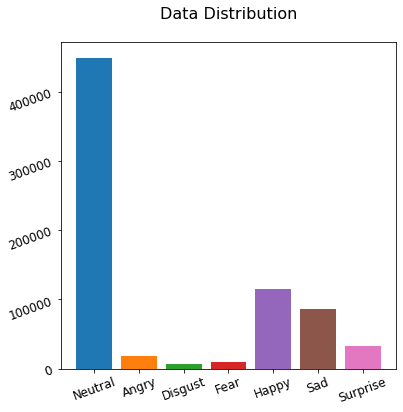

Number of images:	254674
Distribution:  {'Neutral': 156207, 'Angry': 6736, 'Disgust': 986, 'Fear': 8197, 'Happy': 36120, 'Sad': 30537, 'Surprise': 15891}


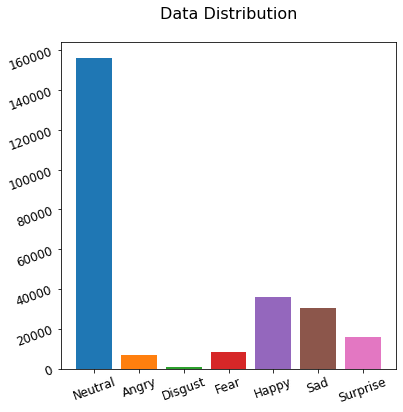

Number of images:	997332
Distribution:  {'Test': 997332}


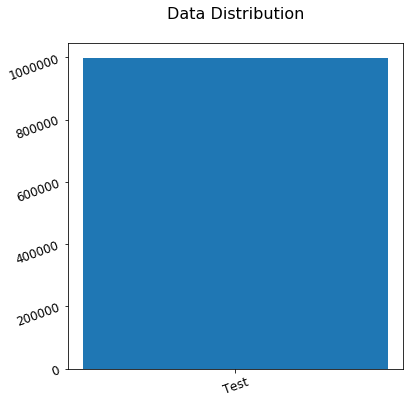

In [7]:
ds.view_emotion_summary(ds.a_idx_train, figsize=(6,6))
ds.view_emotion_summary(ds.a_idx_valid, figsize=(6,6))
ds.view_emotion_summary(ds.a_idx_test, figsize=(6,6));

Number of images:	720365
--------------------
Process va_valence: 
[0.148 0.148 0.148 ... 0.89  0.874 0.874]
Invalid distribution: Empty


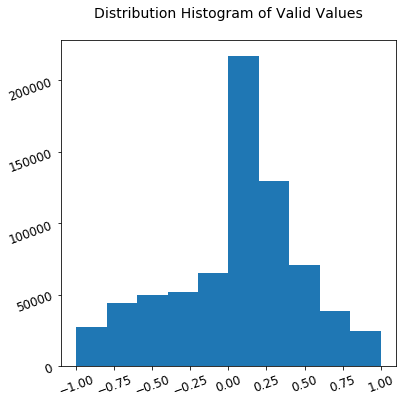

--------------------
Process va_arousal: 
[0.352 0.36  0.362 ... 0.874 0.874 0.874]
Invalid distribution: Empty


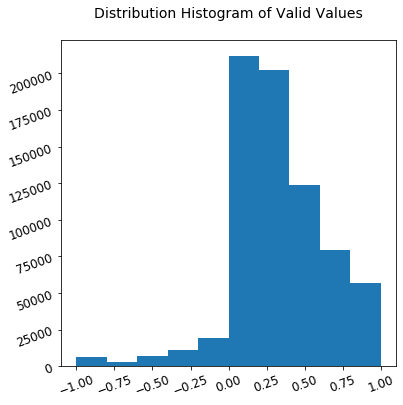

Number of images:	254674
--------------------
Process va_valence: 
[-1.    -1.    -1.    ... -0.681 -0.701 -0.703]
Invalid distribution: Empty


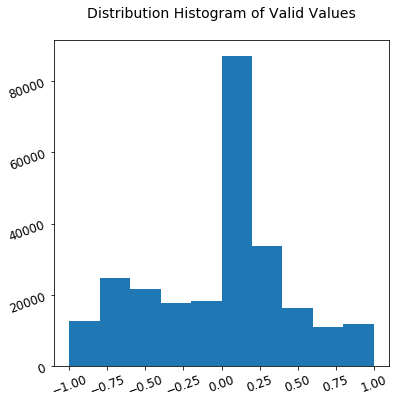

--------------------
Process va_arousal: 
[0.748 0.748 0.748 ... 0.599 0.608 0.634]
Invalid distribution: Empty


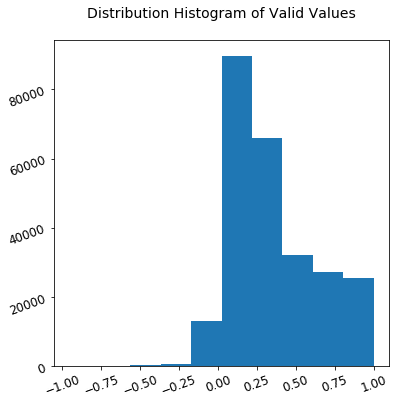

Number of images:	714986
--------------------
Process va_valence: 
[-2. -2. -2. ... -2. -2. -2.]
Invalid distribution:  {'Test': 714986}
Valid distribution: Empty
--------------------
Process va_arousal: 
[-2. -2. -2. ... -2. -2. -2.]
Invalid distribution:  {'Test': 714986}
Valid distribution: Empty


In [8]:
ds.view_va_summary(ds.a_idx_train, figsize=(6,6))
ds.view_va_summary(ds.a_idx_valid, figsize=(6,6))
ds.view_va_summary(ds.a_idx_va_test, figsize=(6,6))

In [9]:
train_loader = VAFramesExprImageBalancedDataLoader(ds.a_idx_train, ds.a_scheme_train, ds, 
                                    n_classes = 7,
                                    n_blocks = params["n_blocks"],
                                    transforms= valid_aug(224),
                                    mode = "valid", 
                                    has_balance=False, 
                                    balanced_mode = "", 
                                    capacity = 0,  
                                    preprocessing_image_fn = None)

valid_loader = VAFramesExprImageBalancedDataLoader(ds.a_idx_valid, ds.a_scheme_valid, ds, 
                                    n_classes = 7,
                                    n_blocks = params["n_blocks"],
                                    transforms= valid_aug(224),
                                    mode = "valid", 
                                    has_balance=False, 
                                    balanced_mode = "", 
                                    capacity = 0,  
                                    preprocessing_image_fn = None)

test_loader = VAFramesExprImageBalancedDataLoader(ds.a_idx_test, ds.a_scheme_test, ds, 
                                    n_classes = 7,
                                    n_blocks = params["n_blocks"],
                                    transforms= valid_aug(224),
                                    mode = "test", 
                                    has_balance=False, 
                                    balanced_mode = "", 
                                    capacity = 0,  
                                    preprocessing_image_fn = None)

test_va_loader = VAFramesExprImageBalancedDataLoader(ds.a_idx_va_test, ds.a_scheme_va_test, ds, 
                                    n_classes = 7,
                                    n_blocks = params["n_blocks"],
                                    transforms= valid_aug(224),
                                    mode = "test", 
                                    has_balance=False, 
                                    balanced_mode = "", 
                                    capacity = 0,  
                                    preprocessing_image_fn = None)

(224, 224, 3) (32, 224, 224, 3) (7,) 0.37 0.203
(224, 224, 3) (32, 224, 224, 3) (7,) 0.748 -0.879
(224, 224, 3) (32, 224, 224, 3) [None, 0.128, 0.0]
(224, 224, 3) (32, 224, 224, 3) [None, -2.0, -2.0]
Training
View 3D Images: Emotion = Happy - 0.37 - 0.203


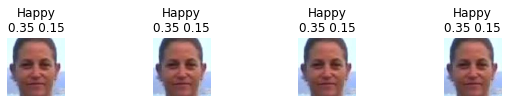

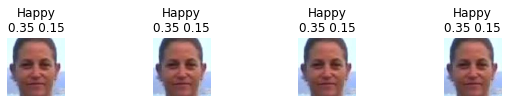

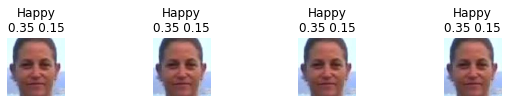

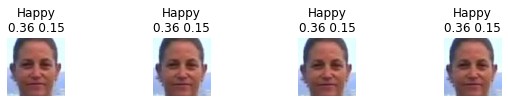

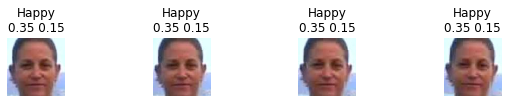

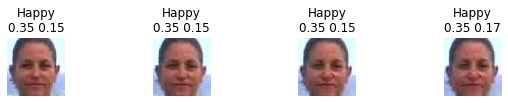

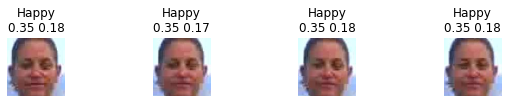

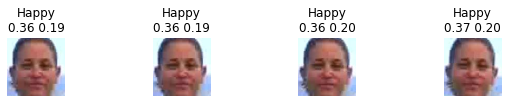

Validating
View 3D Images: Emotion = Neutral - 0.748 - -0.879


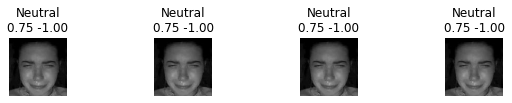

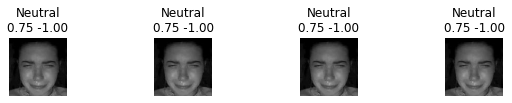

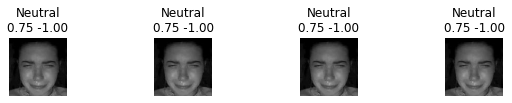

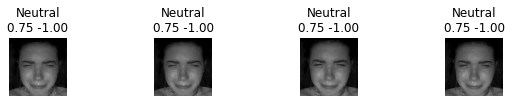

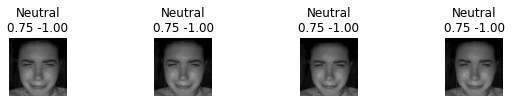

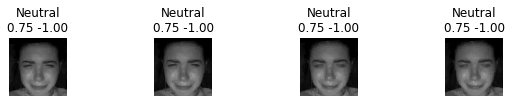

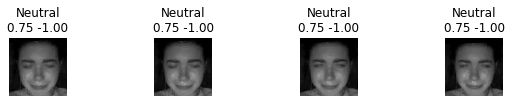

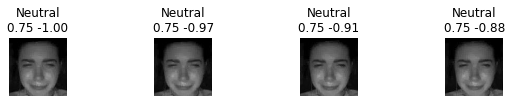

Testing
View 3D Images: Emotion = Unknown - 0.128 - 0.0


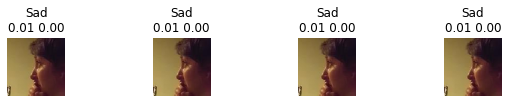

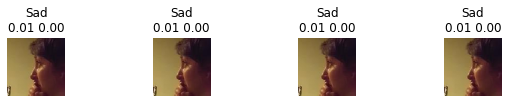

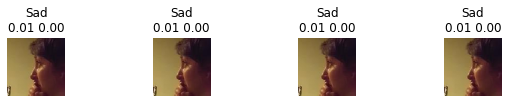

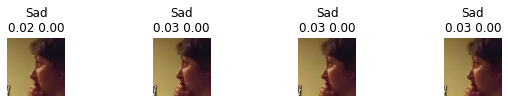

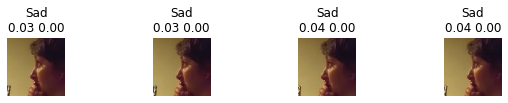

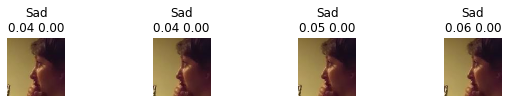

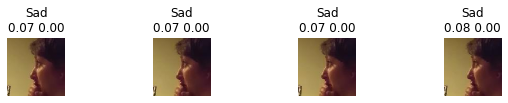

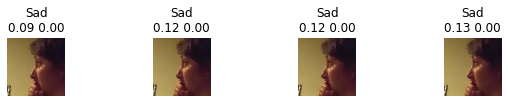

Testing VA
View 3D Images: Emotion = Unknown - -2.0 - -2.0


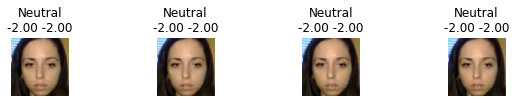

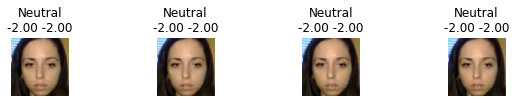

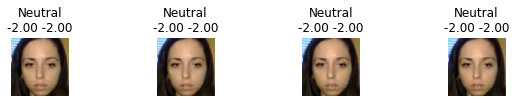

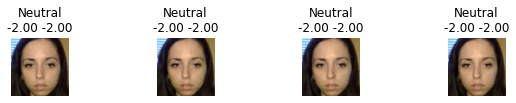

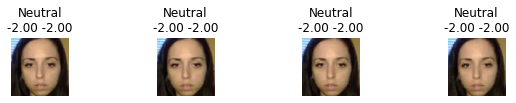

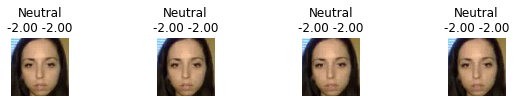

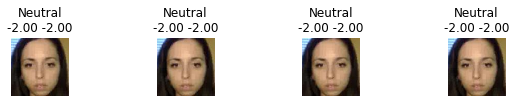

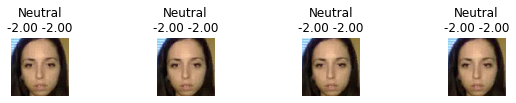

In [10]:
x, y = train_loader[20]
print(x[0].shape, x[1].shape, y[0].shape, y[1], y[2])
x, y = valid_loader[20]
print(x[0].shape, x[1].shape, y[0].shape, y[1], y[2])
x, y = test_loader[20]
print(x[0].shape, x[1].shape, y)
x, y = test_va_loader[20]
print(x[0].shape, x[1].shape, y)

print("Training")
train_loader.view_image(20, cols = 4)
print("Validating")
valid_loader.view_image(20, cols = 4)
print("Testing")
test_loader.view_image(20, cols = 4)
print("Testing VA")
test_va_loader.view_image(20, cols = 4)

In [11]:
train_gen = DataGenerator(dataloader = train_loader, 
                          has_dynamic_blocks = False,
                          dynamic_blocks = [4, 8, 16, 32],
                          preprocessing_image_fn = vggface2_preprocessing_input,
                          batch_size = params["batch_size"], 
                          shuffle = False, seed = None )
print("Train: ")
x, y = next(train_gen)
print(x[0].shape, np.min(x[0]), np.max(x[0]))
print(x[1].shape, np.min(x[1]), np.max(x[1]))
print(y[0].shape, y[1].shape, y[2].shape)

valid_gen = DataGenerator(dataloader = valid_loader, 
                          has_dynamic_blocks = False,
                          dynamic_blocks = [4, 8, 16, 32],
                          preprocessing_image_fn = vggface2_preprocessing_input,
                          batch_size = params["batch_size"], 
                          shuffle = False, seed = None )
print("Valid: ")
x, y = next(valid_gen)
print(x[0].shape, np.min(x[0]), np.max(x[0]))
print(x[1].shape, np.min(x[1]), np.max(x[1]))
print(y[0].shape, y[1].shape, y[2].shape)

test_gen = DataGenerator(dataloader = test_loader, 
                         has_dynamic_blocks = False,
                         dynamic_blocks = [4, 8, 16, 32],
                         preprocessing_image_fn = vggface2_preprocessing_input,
                         batch_size = params["batch_size"], 
                         shuffle = False, seed = None )
print("Test: ")
x, y = next(test_gen)
print(x[0].shape, x[1].shape, y)

test_va_gen = DataGenerator(dataloader = test_va_loader, 
                         has_dynamic_blocks = False,
                         dynamic_blocks = [4, 8, 16, 32],
                         preprocessing_image_fn = vggface2_preprocessing_input,
                         batch_size = params["batch_size"], 
                         shuffle = False, seed = None )
print("Test VA: ")
x, y = next(test_va_gen)
print(x[0].shape, x[1].shape, y)

Train: 
(16, 224, 224, 3) -106.0912 163.5047
(16, 32, 224, 224, 3) -106.0912 163.5047
(16, 7) (16, 1) (16, 1)
Valid: 
(16, 224, 224, 3) -131.0912 79.5047
(16, 32, 224, 224, 3) -131.0912 79.5047
(16, 7) (16, 1) (16, 1)
Test: 
(16, 224, 224, 3) (16, 32, 224, 224, 3) None
Test VA: 
(16, 224, 224, 3) (16, 32, 224, 224, 3) None


## 3. Setup Model

In [12]:
if params["run_train"]==True or params["run_valid"]==True or params["run_test"]==True or params["run_test_va"] == True:
    # Load model VGGFace
    K.clear_session()
    model_base = VGGFace2_AffWild2_V0(nb_classes = 7,dropout = [0.0, 0.0])
    model_base.load_weights(params["model_base_path"])
    
    # Summary
    model_base.summary()
    
    # Free_weights for fine-tuning
    idx_predictions = -1
    idx_features = -1
    idx_conv = -1

    layer_predictions_name = "predictions"
    layer_conv_name = "conv4_1_1x1_reduce"
    layer_feature_name = "features"

    for idx in range(len(model_base.layers)):
        if model_base.layers[idx].name == layer_feature_name: # features, 
            idx_features = idx
        elif model_base.layers[idx].name == layer_conv_name: # conv4_1_1x1_reduce
            idx_conv = idx
        elif model_base.layers[idx].name == layer_predictions_name: # conv4_1_1x1_reduce
            idx_predictions = idx

    for idx in range(len(model_base.layers)):
        if idx<idx_conv:
            model_base.layers[idx].trainable = False
        else:
            model_base.layers[idx].trainable = True
    # for

    print(idx_features)
    print(idx_conv)
    print(idx_predictions)

    model_base_fea = Model(inputs = model_base.input, 
                        outputs = model_base.layers[idx_features].output)
    model_base_pre = Model(inputs = model_base.input, 
                        outputs = model_base.layers[idx_predictions].output)
    
    # Load model
    model_config = dict(
        model_base_fea = model_base_fea, 
        model_base_pre = model_base_pre, 
        nb_classes = 7,
        fc_regre_finals = [1024, 1024], 
        fc_regre_dropout = [0.1, 0.1, 0.1],
        fc_class_finals = [1024, 1024], 
        fc_class_dropout = [0.1, 0.1, 0.1]
    )
    model = EXP_VA_FRAMES_V0(**model_config)
    
    # Load Weights
    print(params["weights_path"])
    model.load_weights(params["weights_path"])
    
    # Model Summary
    model.summary()
    
    if params["use_parallel_model"] == True:
        model = multi_gpu_model(model, gpus = len(params["gpus"]))
    # if
# if    

## 4. Predict

### 4.1. Train

In [13]:
if params["run_train"] == True:
    train_gen.reset()

    if params["debug"] == True:
        steps = 50
        y_pred = model.predict(train_gen, steps = steps,
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])
    else:
        y_pred = model.predict(train_gen, 
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])
    # if
# if

In [14]:
if params["run_train"] == True:
    y_results = {}
    y_results["emotion"]    = y_pred[0]
    y_results["aro_ccc"]    = y_pred[1]
    y_results["val_ccc"]    = y_pred[2]
    y_results["valaro_mse"] = y_pred[3]

    save_path = os.path.join(params["results_dir"], f"train_{params['n_blocks']}.npz")
    print(f"Save Train: {save_path}")
    np.savez(save_path, **y_results)
# if

### 4.2. Valid

In [15]:
if params["run_valid"] == True:
    valid_gen.reset()

    if params["debug"] == True:
        steps = 50
        y_pred = model.predict(valid_gen, steps = steps, 
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])
    else:
        y_pred = model.predict(valid_gen,                                
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])
    # if
# if

In [16]:
if params["run_valid"] == True:
    y_results = {}
    y_results["emotion"]    = y_pred[0]
    y_results["aro_ccc"]    = y_pred[1]
    y_results["val_ccc"]    = y_pred[2]
    y_results["valaro_mse"] = y_pred[3]

    save_path = os.path.join(params["results_dir"], f"valid_{params['n_blocks']}.npz")
    print(f"Save Valid: {save_path}")
    np.savez(save_path, **y_results)
# if

### 4.3. Test

In [18]:
if params["run_test"] == True:    
    test_gen.reset()

    if params["debug"] == True:
        steps = 50
        y_pred = model.predict(test_gen, steps = steps,
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])
    else:
        y_pred = model.predict(test_gen,                                
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])
# if

In [19]:
if params["run_test"] == True:    
    y_results = {}
    y_results["emotion"]    = y_pred[0]
    y_results["aro_ccc"]    = y_pred[1]
    y_results["val_ccc"]    = y_pred[2]
    y_results["valaro_mse"] = y_pred[3]

    save_path = os.path.join(params["results_dir"], f"test_{params['n_blocks']}.npz")
    print(f"Save Test: {save_path}")
    np.savez(save_path, **y_results)
# if

### 4.4. Test VA

In [20]:
if params["run_test_va"] == True:    
    test_va_gen.reset()

    if params["debug"] == True:
        steps = 50
        y_pred = model.predict(test_va_gen, steps = steps,
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])                               
    else:
        y_pred = model.predict(test_va_gen, 
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])                                    
# if

In [21]:
if params["run_test_va"] == True:    
    y_results = {}
    y_results["emotion"]    = y_pred[0]
    y_results["aro_ccc"]    = y_pred[1]
    y_results["val_ccc"]    = y_pred[2]
    y_results["valaro_mse"] = y_pred[3]

    save_path = os.path.join(params["results_dir"], f"test_va_{params['n_blocks']}.npz")
    print(f"Save Test: {save_path}")
    np.savez(save_path, **y_results)
# if

## 5. Evaluation

### 5.1. Train

In [22]:
if params["val_train"] == True:   
    
    load_path  = os.path.join(params["results_dir"], f"train_{params['n_blocks']}.npz")
    a_idx_data = ds.a_idx_train

    y_results = dict(np.load(load_path, allow_pickle=True))
    
    y_pred_emotion_label = emotiw_affwild2_mapping[np.argmax(y_results["emotion"], axis = 1)]
    y_true_emotion_label = ds.df_frames.loc[a_idx_data]["expr_emotion"].values
    
    a_summary_report = model_report(y_true_emotion_label, y_pred_emotion_label, affwild2_name)
    s_summary_report = buffer_print_string(print_summary, a_summary_report)
    print(s_summary_report)
    
    f1   = a_summary_report["model_f1_avg_weighted"]
    acc  = a_summary_report["model_acc_all"]
    expr = f1 * 0.66 + acc * 0.33
    print(f"f1: {f1}")
    print(f"acc: {acc}")
    print(f"expr: {expr}")
    
    plt.figure(figsize=(6,6))
    plot_confusion_matrix(y_true_emotion_label, y_pred_emotion_label, 
                          title='Average accuracy \n ( Accuracy={acc:.2f} )\n',
                          classes = affwild2_name)
    
    aro_pred = y_results["aro_ccc"].flatten()
    val_pred = y_results["val_ccc"].flatten()
    aro_true = ds.df_frames.loc[a_idx_data]["va_arousal"].values
    val_true = ds.df_frames.loc[a_idx_data]["va_valence"].values

    aro_ccc1 = concordance_cc2(aro_true, aro_pred)
    aro_ccc2 = ccc_numpy(aro_true, aro_pred)
    val_ccc1 = concordance_cc2(val_true, val_pred)
    val_ccc2 = ccc_numpy(val_true, val_pred)

    avg_ccc1 = (aro_ccc1 + val_ccc1) / 2.0
    avg_ccc2 = (aro_ccc2 + val_ccc2) / 2.0

    print(f"aro: {aro_ccc1}, {aro_ccc2}")
    print(f"val: {val_ccc1}, {val_ccc2}")
    print(f"valaro_avg: {avg_ccc1}, {avg_ccc2}")
# if

## 5.2. Valid

Classification Report: 
               precision    recall  f1-score   support

     Neutral       0.79      0.17      0.28    156207
       Angry       0.11      0.50      0.18      6736
     Disgust       0.01      0.10      0.02       986
        Fear       0.17      0.31      0.22      8197
       Happy       0.36      0.67      0.47     36120
         Sad       0.34      0.55      0.42     30537
    Surprise       0.19      0.62      0.29     15891

    accuracy                           0.33    254674
   macro avg       0.28      0.42      0.27    254674
weighted avg       0.59      0.33      0.32    254674

Confustion Matrix Int: 
 [[26118 22721  5117  7771 37114 25642 31724]
 [  492  3343   137   462   757   727   818]
 [   16   301    98    33   237   129   172]
 [  721   555   990  2524   200  2121  1086]
 [ 2060  1036   370   434 24361  2764  5095]
 [ 2852  1095  1144  3038  3393 16712  2303]
 [ 1005  1389   372   580  1802   939  9804]]

Confustion Matrix Norm: 
 [[16.72 14

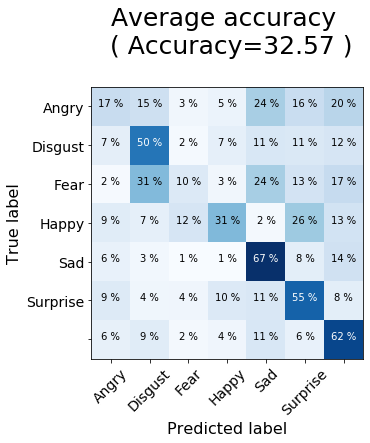

In [23]:
if params["val_valid"] == True:   
    
    load_path  = os.path.join(params["results_dir"], f"valid_{params['n_blocks']}.npz")
    a_idx_data = ds.a_idx_valid

    y_results = dict(np.load(load_path, allow_pickle=True))
    
    y_pred_emotion_label = emotiw_affwild2_mapping[np.argmax(y_results["emotion"], axis = 1)]
    y_true_emotion_label = ds.df_frames.loc[a_idx_data]["expr_emotion"].values
    
    a_summary_report = model_report(y_true_emotion_label, y_pred_emotion_label, affwild2_name)
    s_summary_report = buffer_print_string(print_summary, a_summary_report)
    print(s_summary_report)
    
    f1   = a_summary_report["model_f1_avg_weighted"]
    acc  = a_summary_report["model_acc_all"]
    expr = f1 * 0.66 + acc * 0.33
    print(f"f1: {f1}")
    print(f"acc: {acc}")
    print(f"expr: {expr}")
    
    plt.figure(figsize=(6,6))
    plot_confusion_matrix(y_true_emotion_label, y_pred_emotion_label, 
                          title='Average accuracy \n ( Accuracy={acc:.2f} )\n',
                          classes = affwild2_name)
    
    aro_pred = y_results["aro_ccc"].flatten()
    val_pred = y_results["val_ccc"].flatten()
    aro_true = ds.df_frames.loc[a_idx_data]["va_arousal"].values
    val_true = ds.df_frames.loc[a_idx_data]["va_valence"].values

    aro_ccc1 = concordance_cc2(aro_true, aro_pred)
    aro_ccc2 = ccc_numpy(aro_true, aro_pred)
    val_ccc1 = concordance_cc2(val_true, val_pred)
    val_ccc2 = ccc_numpy(val_true, val_pred)

    avg_ccc1 = (aro_ccc1 + val_ccc1) / 2.0
    avg_ccc2 = (aro_ccc2 + val_ccc2) / 2.0

    print(f"aro: {aro_ccc1}, {aro_ccc2}")
    print(f"val: {val_ccc1}, {val_ccc2}")
    print(f"valaro_avg: {avg_ccc1}, {avg_ccc2}")
# if